# Imports and Setup

## Asynchronous Execution

In [34]:
import threading

In [35]:
# multithreading lock to pause experiment loop during user feedback collection
experiment_lock = threading.Event()
experiment_lock.set()

In [36]:
# multithreading lock to terminate the experiment thread prematurely
quit_lock = threading.Event()

## Logging

In [37]:
import logging
import datetime

## Graphical User Interface

In [38]:
import ipywidgets as ipw
import matplotlib.pyplot as plt
from matplotlib import path
from matplotlib.colors import Normalize
import ternary

# enable ipympl
%matplotlib widget

# turn on interactive mode so that plots only appear where we want it to
plt.ioff()

In [39]:
# create the gui elements
fig, tax = ternary.figure(scale=0.6)

pause_button = ipw.Button(description='Pause')
undo_button = ipw.Button(description='Undo Point')
continue_button = ipw.Button(description='Continue')
quit_button = ipw.Button(description='Quit')

In [40]:
# assemble the gui elements
buttons = ipw.HBox([pause_button, undo_button, continue_button, quit_button])
gui = ipw.VBox([fig.canvas, buttons])

In [41]:
# store a list of points where the user has clicked
points = []

### Plot Callbacks

In [42]:
def draw_background_plot(tax):
    '''
    Plot the data from the current experiment loop.

    Parameters
    ----------
    tax: the ternary axes on which to plot the data
    '''

    # empty the ternary plot
    tax.get_axes().clear()
    tax.set_background_color('white')

    # plot decoration
    tax.right_corner_label("$Fe_{0.4}Ga_{0.6}$", fontsize=20)
    tax.top_corner_label("$Fe_{0.4}Pd_{0.6}$", fontsize=20)
    tax.left_corner_label("$Fe$", fontsize=20)

    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()

    tax.boundary()

    # get all the point colors in advance because the "edgecolors" parameter 
    # doesn't accept a list of values like the parameters "c" does
    point_colors = plt.cm.get_cmap()(Normalize()(all_predicted_labels[-1]))

    # plot all points as empty circles
    tax.get_axes().scatter(cartesian[:, 0],
                           cartesian[:, 1], 
                           edgecolors=point_colors,
                           facecolors='none',
                           marker='o')

    # fill measured points
    tax.get_axes().scatter(cartesian[measured[:-1], 0],
                           cartesian[measured[:-1], 1], 
                           c=point_colors[measured[:-1]],
                           marker='o')

    # plot next point
    tax.get_axes().scatter(cartesian[measured[-1], 0],
                           cartesian[measured[-1], 1], 
                           marker='x', color='m')

    logging.info('Background plot drawn')

    plt.draw()


In [43]:
def draw_user_points(tax):
    '''
    Draw the points where the user has clicked.

    Parameters
    ----------
    tax: the ternary axes on which to draw the points
    '''

    # create separate x and y coordinate lists for every point in points
    x, y = zip(*points)

    tax.get_axes().plot(x, y, 'k*-')

    logging.info('User points drawn')

    plt.draw()

In [44]:
def plot_callback(event):
    '''
    Store the point where the user clicked and add it to the plot.

    Parameters
    ----------
    event: a structure which has information about the mouse event
    '''

    logging.debug('User clicked on plot')
    
    if not experiment_lock.is_set():
        # add the mouse position (in data coordinates) to the points list
        points.append([event.xdata, event.ydata])

        logging.info('Point added')

        draw_user_points(tax)

cid = fig.canvas.mpl_connect('button_press_event', plot_callback)

### Button Callbacks

In [45]:
def pause_callback(button):
    '''
    Set the internal flag of the experiment loop threading Event object to false.

    Parameters
    ----------
    button: the instance of button that was clicked
    '''

    logging.debug('User clicked pause button')
    
    if experiment_lock.is_set():
        experiment_lock.clear()

        logging.info('Experiment lock cleared')

pause_button.on_click(pause_callback)

In [46]:
def undo_callback(button):
    '''
    Removes the last point where the user clicked and updates the plot.

    Parameters
    ----------
    button: the instance of button that was clicked
    '''

    logging.debug('User clicked undo button')

    # removed = points.pop()

    # empty the ternary plot
    tax.get_axes().clear()
    tax.set_background_color()

    # re-draw without the deleted point
    draw_background_plot(tax)
    draw_user_points(tax)

    logging.info('Removed point')

undo_button.on_click(undo_callback)

In [47]:
def continue_callback(button):
    '''
    Set the internal flag of the experiment loop threading Event object to true.

    Parameters
    ----------
    button: the instance of button that was clicked
    '''

    logging.debug('User clicked continue button')
    
    if not experiment_lock.is_set():
        experiment_lock.set()

        logging.info('Experiment lock set')

continue_button.on_click(continue_callback)

In [48]:
def quit_callback(button):
    '''
    Set the internal flag of the quit threading Event object to true, causing the experiment thread to terminate on the next time through the loop.

    Parameters
    ----------
    button: the instance of button that was clicked
    '''

    logging.debug('User clicked quit button')

    quit_lock.set()

    logging.info('Quit lock set')

quit_button.on_click(quit_callback)

## CAMEO

In [49]:
# get the simulation test data
# !wget -O CAMEO2_support_files_220104a.zip https://drive.google.com/u/0/uc?id=1UnKijzN_6shj-T2r37Jm2V6PSqTJMO-6&export=download
# !unzip -o CAMEO2_support_files_220104a.zip

In [50]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.ci_utils import ci_niter
from sklearn.manifold import spectral_embedding
from sklearn.mixture import GaussianMixture
from scipy.spatial import Voronoi
from scipy.spatial.distance import pdist, squareform
from ternary.helpers import project_sequence
from scipy.io import loadmat
from scipy.stats import entropy

In [51]:
def phase_mapping(X, num_clusters, random_state):
    '''
    Cluster data using spectral clustering and a Gaussian mixture model

    Parameters
    ----------
    X: m x n matrix - m rows of n dimensional data
    num_clusters: number of groups to cluster data into

    Returns
    -------
    cl: clustering labels for each sample
    cluster_prob: the probability for each sample to belong to each cluster
    '''

    K = similarity_matrix(X, 'cosine')

    if X.shape[0] <= num_clusters:
        # fewer data points than clusters, each point gets its own cluster
        cluster_prob = np.eye(X.shape[0])
    else:
        x_se = spectral_embedding(adjacency=K,
                                  n_components=num_clusters,
                                  random_state=random_state)
        model = GaussianMixture(n_components=num_clusters,
                                covariance_type='diag',
                                n_init=10,
                                random_state=random_state).fit(x_se)

        cluster_prob = model.predict_proba(x_se)

    cl = np.argmax(cluster_prob, axis=1).flatten()
    return cl, cluster_prob


In [52]:
def composition_to_graph(T):
    '''
    Use the composition data to identify nearby neighbors graph in
    composition-space.

    Parameters
    ----------
    T: n x 3 matrix - n rows of composition data in ternary coordinate space

    Returns
    -------
    S: n x n matrix - symmetric adjacency matrix
    '''

    N = T.shape[0]
    XYc = np.array(list(zip(*project_sequence(T))))
    vor = Voronoi(XYc)
    points_separated = vor.ridge_points
    S = np.zeros((N, N))
    for i in range(points_separated.shape[0]):
        S[points_separated[i, 0], points_separated[i, 1]] = 1
        S[points_separated[i, 1], points_separated[i, 0]] = 1
    return S

In [53]:
def plot_graph(S, XY):
    '''
    Plot the graph learned from composition positions.

    Parameters
    ----------
    S: n x n matrix - symmetric adjacency matrix
    XY: n x 2 matrix - n rows of composition data in cartesian coordinates
    '''

    r, c = np.nonzero(S)
    for i in range(r.shape[0]):
        xx = [XY[r[i], 0], XY[c[i], 0]]
        yy = [XY[r[i], 1], XY[c[i], 1]]
        plt.plot(xx, yy, c=np.asarray([.8, .8, .8]))
        plt.plot(xx, yy, 'k.')

In [54]:
def prune_graph(S, XY, dist_ratio, num_nearest_neighbors):
    '''
    Remove edges from the graph that connect points which are too far away.

    Parameters
    ----------
    S: n x n matrix - symmetric adjacency matrix
    XY: n x 2 matrix - n rows of composition data in cartesian coordinates
    dist_ratio: adjusts the cutoff distance
    num_nearest_neighbors: desired degree for data vertices
    '''

    D = squareform(pdist(XY))
    mD = np.sort(D, 0)
    mD = mD[num_nearest_neighbors, :]
    S_ = S.copy()
    for i in range(S.shape[0]):
        d = D[i, :]
        S_[i, d > dist_ratio*mD[i]] = 0
        S_[d > dist_ratio*mD[i], i] = 0
    return S_

In [55]:
def similarity_matrix(X, metric, sigma=1):
    '''
    Calculate and return the similarity matrix used in spectral clustering.

    Parameters
    ----------
    X: m x n matrix - m rows of n dimensional data
    metric: distance metric passed to scipy.spatial.distance.pdist()
    sigma: scaling factor for Gaussian radial basis function (default=1)
    '''

    distance = squareform(pdist(X, metric))
    W = np.exp(-(distance**2) / (2*sigma**2))
    return W

In [56]:
def gpc_phasemapping(xy_curr, labels_curr, xy_full, num_clusters,
                     weight_prior=None):
    '''
    Take clustering labels for the samples and then extrapolate them throughout
    composition space, segmenting the XY space into 'phase regions'.

    Parameters
    ----------
    xy_curr: cartesian coordinates of measured data points
    labels_curr: cluster labels for those data
    xy_full: cartesian coordinates of measured and new, query data points
    num_clusters: the number of clusters we're assuming exist
    weight_prior: variance coefficient of (optional) prior kernel

    Returns
    -------
    y_mean: data point label predictions
    y_variance: data point label variances
    f_mean: data point latent GP predictions
    f_variance: data point latent GP variances
    '''

    data = (xy_curr, labels_curr)

    if weight_prior is None:
        kernel = gpflow.kernels.Matern32(lengthscales=[1, 1])
    else:
        prior_kernel = gpflow.kernels.SquaredExponential(active_dims=[2],
                                                         lengthscales=0.001,
                                                         variance=weight_prior)

        # fix the prior kernel lengthscale and variance
        gpflow.utilities.set_trainable(prior_kernel.parameters[1], False)
        gpflow.utilities.set_trainable(prior_kernel.parameters[0], False)
                                                         
        kernel = gpflow.kernels.Matern32(active_dims=[0, 1]) + prior_kernel

    invlink = gpflow.likelihoods.RobustMax(num_clusters)

    likelihood = gpflow.likelihoods.MultiClass(num_clusters, invlink=invlink)

    model = gpflow.models.VGP(data=data,
                              kernel=kernel,
                              likelihood=likelihood,
                              num_latent_gps=num_clusters)

    # hyperparameter optimization
    opt = gpflow.optimizers.Scipy()
    _ = opt.minimize(model.training_loss,
                     model.trainable_variables,
                     options={'maxiter': ci_niter(1000)})

    # Poisson process for the full XY coordinates
    y = model.predict_y(xy_full)
    y_mean = y[0].numpy()
    y_variance = y[1].numpy()

    # (non-squeezed) probabilistic function for class labels
    f = model.predict_f(xy_full)
    f_mean = f[0].numpy()
    f_variance = f[1].numpy()

    return y_mean, y_variance, f_mean, f_variance

## Experiment Loop

In [57]:
data = loadmat('FeGaPd_full_data_220104a.mat')

# composition data in cartesian coordinates
composition = data['C']
idx = [1, 2, 0]
cartesian = np.array(list(zip(*project_sequence(composition[:, idx]))))

# x ray diffraction data
xrd = data['X'][:, 631:1181]

# true phase mapping labels
true_labels = data['labels_col']

# list of all the predicted labels to compare to the true labels
all_predicted_labels = []

initial_num_measurements = 20
num_clusters = 5
num_total = cartesian.shape[0]

In [58]:
# seed the numpy random number generation for reproducability
seed = 0
rng = np.random.RandomState(seed)
tf.random.set_seed(seed)

In [59]:
# initialize these variables so we can access them in the main thread
# measured = rng.permutation(num_total)[:initial_num_measurements]
measured = [163]
labels = []
y_mean = []
acquisition = []
next_sample = None

In [60]:
def main():
    '''
    Run the calculation loop while checking if the user is waiting to
    provide input. If so, pause the loop, collect input, then resume.
    '''

    global all_predict_labels

    global measured
    global labels
    global y_mean
    global acquisition
    global next_sample

    global points

    user_labels = None

    for i in range(num_total - initial_num_measurements - 1):
        if quit_lock.is_set():
            logging.info(f'Experiment loop quit on iteration {i+1}')
            break

        logging.info(f'Begin experiment loop iteration {i+1}')

        labels, _ = phase_mapping(xrd[measured, :], num_clusters, rng)

        if user_labels is None:
            # user didn't provide input last iteration
            y_mean, _, _, _ = gpc_phasemapping(cartesian[measured, :],
                                               labels,
                                               cartesian,
                                               num_clusters)

            logging.debug('GPC phasemapping WITHOUT user input complete')
        else:
            # use the user labels as input
            data_with_prior = np.column_stack((cartesian, user_labels))

            y_mean, _, _, _ = gpc_phasemapping(data_with_prior[measured, :],
                                               labels,
                                               data_with_prior,
                                               num_clusters,
                                               weight_prior=1)

            logging.debug('GPC phasemapping WITH user input complete')

            # reset the user labels for next iteration
            user_labels = None
        
        # new row of predicted labels, with NaN in place of unmeasured samples
        new_label_row = np.argmax(y_mean, 1)
        all_predicted_labels.append(new_label_row)

        # calculate the next sample point
        acquisition = entropy(y_mean, axis=1)
        next_sample = np.argmax(acquisition)
        measured = np.append(measured, next_sample)
        
        draw_background_plot(tax)

        if not experiment_lock.is_set():
            logging.info('Experiment thread pausing')

            experiment_lock.wait()

            logging.info('Experiment thread continuing')

            if len(points) < 2:
                raise ValueError('User didn\'t add enough points.')
            elif len(points) == 2:
                # user drew a line
                x1, y1 = points[0]
                x2, y2 = points[1]

                # calculate the distance between each point the line
                d = [(x-x1)*(y2-y1)-(y-y1)*(x2-x1) for (x, y) in cartesian]

                user_labels = np.sign(d)
            else:
                # user draw a polygon
                polygon = path.Path(points)

                user_labels = polygon.contains_points(cartesian)

## Data Analysis Utilities

In [61]:
from sklearn.metrics import fowlkes_mallows_score

# Putting It Together

In [62]:
time_string = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')

logging.basicConfig(filename=f'logs/hitl_{time_string}.log',
                    format='%(levelname)-5s [%(asctime)s]: %(message)s',
                    level=logging.INFO)

In [63]:
# begin the experiment in a new thread
experiment_thread = threading.Thread(target=main,
                                     name='experiment')
experiment_thread.start()

In [64]:
# start the gui
gui

In [32]:
logging.debug('Checking if experiment thread is alive...')

result = 'alive' if experiment_thread.is_alive() else 'dead'

logging.debug(f'Experiment thread is {result}')

print(result)

dead


# Data Analysis

In [ ]:
# save predicted labels for later comparison
np.savetxt('predicted_labels.txt', all_predicted_labels)

In [ ]:
# load predicted labels for analysis
all_predicted_labels = np.loadtxt('predicted_labels.txt')

In [65]:
all_predicted_labels = np.array(all_predicted_labels)

In [66]:
# pick one of the 'true' labels to use for comparison
true_labels_set = true_labels[0][0].flatten()

In [67]:
num_experiments = len(all_predicted_labels)

scores = np.zeros(num_experiments)

for i in range(num_experiments):
    scores[i] = fowlkes_mallows_score(true_labels_set, all_predicted_labels[i])


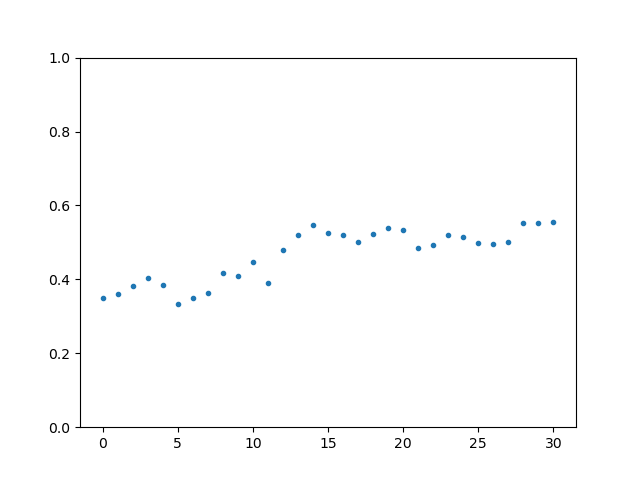

In [68]:
fig, ax = plt.subplots()
ax.plot(scores, '.')
ax.set_ylim([0, 1])
plt.show()